In [1]:
import os
import time
import sys
import itertools
import json
import librosa as lr
import librosa.display as lrd
import numpy as np
import os.path as osp

import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.metrics import mean_squared_error

%matplotlib inline

sys.path.append("..")
from libs.utilities import load_autoencoder_lossfunc, load_autoencoder_model, get_func_name
from libs.processing import pink_noise, take_file_as_noise, \
    make_fragments, unmake_fragments, unmake_fragments_slice, \
    s_to_exp, exp_to_s, s_to_reim, reim_to_s, s_to_db, db_to_s , \
    normalize_spectrum, normalize_spectrum_clean, unnormalize_spectrum  


Using TensorFlow backend.
/home/rmicci18/miniconda3/envs/denoising/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# LOAD LOGS (log order is different from argument list order!)
logs_path = '/home/rmicci18/SingleChannelDenoising_source/train_logs/phase1.json'

with open(logs_path) as f:
    logs = json.load(f)

In [4]:
# some parameters
input_path = '/data/riccardo_datasets/npr_news/ds0/train/NPR_News__03-15-2018_11PM_ET.wav'
sr = 16000
snr = 15
n_fft = 512
hop_length = 128
win_length = 512
frag_hop_length = 16
frag_win_length = 32
os.environ["CUDA_VISIBLE_DEVICES"] = '3'


In [9]:
# variable arguments
normalize_args = [True, False]
proc_func_args = [
    (s_to_exp(1.0),   exp_to_s(1.0)),
    (s_to_exp(2.0),   exp_to_s(2.0)),
    (s_to_exp(1.0/6), exp_to_s(1.0/6)),
    (s_to_reim,       reim_to_s),
    (s_to_db,         db_to_s),
    (s_to_exp(2.0/3), exp_to_s(2.0/3)),
]
args_list = list(itertools.product(normalize_args, proc_func_args))
print('\n'.join(['{:2}. {} {}'.format(i, 'norm' if arg[0] else '    ', get_func_name(arg[1][0])) for i,arg in enumerate(args_list)]))


 0. norm s_to_exp(1.000)
 1. norm s_to_exp(2.000)
 2. norm s_to_exp(0.167)
 3. norm s_to_reim
 4. norm s_to_db
 5. norm s_to_exp(0.667)
 6.      s_to_exp(1.000)
 7.      s_to_exp(2.000)
 8.      s_to_exp(0.167)
 9.      s_to_reim
10.      s_to_db
11.      s_to_exp(0.667)


In [20]:
def run_the_whole_thing(args_index, use_phase=True, trim_negatives=False):
    # collect variable arguments
    normalize, proc_funcs = args_list[args_index]
    proc_func, unproc_func = proc_funcs
    
    
    print('[dn] Loading data from {}...'.format(input_path))
    # load data from file name
    x, _ = lr.load(input_path, sr=sr, duration=30, offset=120)

    # apply noise!
    x_noisy = pink_noise(x=x, sr=sr, snr=snr)

    # convert to TF-domain
    s = lr.stft(x, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    s_noisy = lr.stft(x_noisy, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    # split into fragments
    s_frags = make_fragments(s, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)
    s_frags_noisy = make_fragments(s_noisy, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)
    # apply pre-processing (data representation)
    y_frags = proc_func(s_frags)
    y_frags_noisy = proc_func(s_frags_noisy)
    print('[dn] Generated {} fragments with shape {}'.format(len(y_frags_noisy), y_frags_noisy[0].shape))
    # normalization factors
    nf_frags = np.empty((len(y_frags), 2))
    nf_frags_noisy = np.empty((len(y_frags_noisy), 2))
    y_frags_n = np.zeros_like(y_frags)
    y_frags_noisy_n = np.zeros_like(y_frags_noisy)

    # normalize fragments (batch-wise)
    #y_frags_noisy_n, nf_frags_noisy = normalize_spectrum(y_frags_noisy)
    #print(nf_frags_noisy)


    # normalize fragments (individually)
    for i in range(len(y_frags_noisy)):
        frag_normalized, frag_norm_factors = normalize_spectrum(y_frags[i])
        frag_normalized_noisy, frag_norm_factors_noisy = normalize_spectrum(y_frags_noisy[i])
        y_frags_n[i] = frag_normalized if normalize else y_frags[i]
        y_frags_noisy_n[i] = frag_normalized_noisy if normalize else y_frags_noisy[i]
        nf_frags_noisy[i] = frag_norm_factors_noisy
        nf_frags[i] = frag_norm_factors


    #### LOAD TRAINED MODEL ###
    model_destination_base = '/data/riccardo_models/denoising/phase1'
    model_destination_name = '{}_{}.h5'.format(get_func_name(proc_func), 'norm' if normalize else 'no')
    model_path = osp.join(model_destination_base, model_destination_name)
    time_slice = frag_win_length // 2 - frag_hop_length // 2
    model, lossfunc = load_autoencoder_model(model_path, time_slice=time_slice)


    ### PREDICT DATA ###
    print('[dn] Predicting with trained model...')
    y_frags_pred = model.predict(y_frags_noisy_n)
    print('[dn] Prediction finished! Generated {} fragments'.format(len(y_frags_pred)))


    ### PLOT A FEW PREDICTED FRAGMENTS ###
    specrange = np.linspace(0, len(y_frags_pred), 10, dtype=int)
    print(list(specrange))

    plt.figure(figsize=(18, 6))
    plt.suptitle('Clean (true), noisy, and predicted sample fragments (normalized)')
    rangespan = len(specrange)
    j = 1
    y_frags_pred_dn = np.zeros_like(y_frags_pred)
    for i in range(len(y_frags_pred)):
        # un-normalize (individually)
        y_frags_pred_dn[i] = unnormalize_spectrum(y_frags_pred[i], nf_frags_noisy[i]) if normalize else y_frags_pred[i]
        if i in specrange:        
            plt.subplot(3,rangespan,j)
            lrd.specshow(lr.amplitude_to_db(y_frags_n[i,...,0]), vmin=-10, vmax=5, cmap='coolwarm')

            plt.subplot(3,rangespan,rangespan+j)
            lrd.specshow(lr.amplitude_to_db(y_frags_noisy_n[i,...,0]), vmin=-10, vmax=5, cmap='coolwarm')

            plt.subplot(3,rangespan,rangespan*2+j)
            lrd.specshow(lr.amplitude_to_db(y_frags_pred[i,...,0]), vmin=-10, vmax=5, cmap='coolwarm')

            j += 1


    # un-normalize (batch-wise)
    #y_frags_pred_dn = unnormalize_spectrum(y_frags_pred, nf_frags_noisy)

    # trim negative values
    if trim_negatives:
        y_frags_pred[y_frags_pred < 0] = 0
    s_pred = unproc_func(y_frags_pred, s_frags_noisy) if use_phase else unproc_func(y_frags_pred)

    # undo fragments
    #s_pred = unmake_fragments_slice(s_pred, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length, time_slice=time_slice)
    s_pred = unmake_fragments(s_pred, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)

    # get waveform
    x_pred = lr.istft(s_pred, hop_length=hop_length, win_length=win_length)



    ### PLOT RESULT AND LISTEN ###
    duration = 20
    offset = 2
    l = lr.time_to_frames(duration, sr=sr, n_fft=n_fft, hop_length=hop_length)
    o = lr.time_to_frames(offset, sr=sr, n_fft=n_fft, hop_length=hop_length)
    print(o,l)

    plt.figure(figsize=(18, 5))
    plt.suptitle('True and predicted spectrograms (de-normalized, {} seconds)'.format(duration))

    plt.subplot(211)
    lrd.specshow(lr.amplitude_to_db(np.abs(s[:,o:o+l])), vmin=-50, vmax=25, cmap='coolwarm')
    plt.colorbar()

    plt.subplot(212)
    lrd.specshow(lr.amplitude_to_db(np.abs(s_pred[:,o:o+l])), vmin=-50, vmax=25, cmap='coolwarm')
    plt.colorbar()
    
    print('done!')
    return x_pred, x_noisy
    

[dn] Loading data from /data/riccardo_datasets/npr_news/ds0/train/NPR_News__03-15-2018_11PM_ET.wav...
[dn] Generated 233 fragments with shape (256, 32, 2)
[u] Loading autoencoder model from /data/riccardo_models/denoising/phase1/s_to_reim_no.h5
[dn] Predicting with trained model...
[dn] Prediction finished! Generated 233 fragments
[0, 25, 51, 77, 103, 129, 155, 181, 207, 233]
248 2498
done!


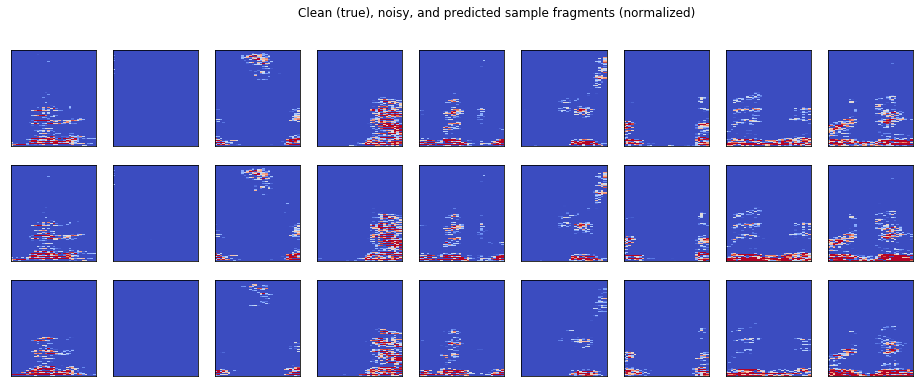

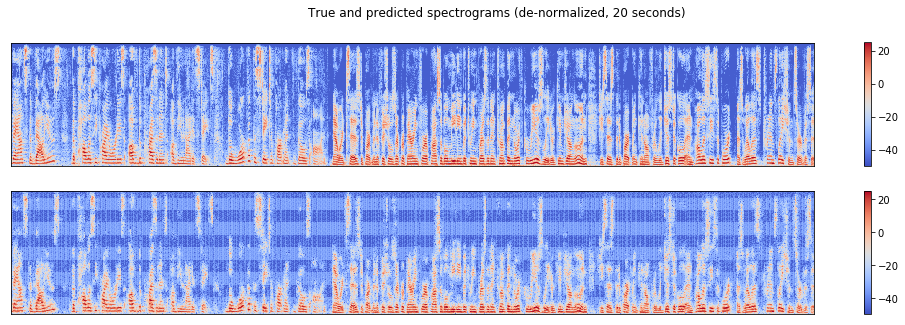

In [21]:
# TEST VARIOUS MODELS HERE

x_pred, x_noisy = run_the_whole_thing(9, use_phase=False, trim_negatives=False)
ipd.Audio(x_pred, rate=sr)
